# 파이썬 클린코드 ver 2

## 1. 코드 포매팅과 도구

- 클린코드란?
- 클린코드가 성공적인 소프트웨어 엔지니어링 프로젝트를 위해 왜 중요한 요소인가?

In [1]:
from dataclasses import dataclass
@dataclass
class Point:
    lat: float
    lon: float

In [2]:
Point.__annotations__

{'lat': float, 'lon': float}

In [3]:
Point(1, 2)

Point(lat=1, lon=2)

### 도구 설정

- 이 코드를 동료 개발자가 쉽게 이해하고 따라갈 수 있을까?
- 업무 도메인에 대해서 말하고 있는가?
- 팀에 새로 합류하는 사람도 쉽게 이해하고 효과적으로 작업할 수 있을까?

-> 엔지니어나 팀 리더가 PEP-8을 준수하였는지 항상 확인하도록 할 필요 없이 빌드의 결과가 자동으로 답변을 할 수 있도록 해야 한다.

---
검증도구 목록
* mypy
* pytype
* pylint
* Coala
* black

In [1]:
pip install mypy

     |████████████████████████████████| 11.3 MB 15.0 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
from collections.abc import Iterable
import logging

logger = logging.getLogger(__name__)

def broadcast_notification(
    message: str,
    relevant_user_emails: Iterable[str]
):
    for email in relevant_user_emails:
        logger.info(f"{message} 메시지를 {email}에게 전달")

In [7]:
broadcast_notification("welcome", "user1@domain.com")

## 2. 파이썬스러운 코드

- 아이디어를 파이썬으로 표현하는 방식과 그 특수성
---
목표
- 인덱스와 슬라이스를 이해하고 인덱싱 가능한 객체를 올바른 방식으로 구현하기
- 시퀀스와 이터러블 구현하기
- 컨텍스트 관리자를 만드는 모범 사례 연구 그리고 어떻게 효율적으로 작성할 수 있는지
- 매직 메서드를 사용해 보다 관용적인 코드 구현
- 파이썬에서 부작용을 유발하는 흔한 실수 피하기

In [8]:
my_numbers = (1, 1, 2, 3, 5, 8, 13, 21)

In [11]:
interval = slice(1, 7, 2)  # 시작, 끝, interval
my_numbers[interval]

(1, 3, 8)

In [12]:
interval = slice(None, 3)
my_numbers[interval] == my_numbers[:3]

True

## 5. 데코레이터를 사용한 코드 개선

### 파이썬의 데코레이터 (p180)

- 파이썬에서 함수는 일반적인 객체일 뿐
- 데코레이터 구문은 가독성을 크게 향상시킨다
- 클래스 데코레이터는 코드 재사용과 DRY 원칙의 모든 이점을 공유한다.

(https://kukuta.tistory.com/325)

- 함수 데코레이터
  - 파라미터의 유효성을 검사하거나 사전조건을 검사
  - 기능 전체를 새롭게 정의
  - 서명을 변경
  - 원래 함수의 결과를 캐시

In [11]:
def add_emoticon(func) :

    def inner() :
         print('=￣ω￣= ', end='')
         func()
    
    return inner
    
def say_hello() :
    print('hello')
    
f = add_emoticon(say_hello)
f()

=￣ω￣= hello


In [17]:
def add_emoticon(func) :

    def inner() :
        print('=￣ω￣= ', end='')
        func()
    
    return inner
    
def say_hello() :
    print('hello')
    
say_hello = add_emoticon(say_hello)
say_hello()  #  =￣ω￣= hello

@add_emoticon  # say_hi = add_emoticon(say_hi)
def say_hi() :
    print('hi')

=￣ω￣= hello


In [16]:
say_hi()

=￣ω￣= hi


In [18]:
class LoginEventSerializer:
    def __init__(self, event):
        self.event = event
    
    def serialize(self) -> dict:
        return {
            "username": self.event.username,
            "password": "**민감한 정보 삭제**",
            "ip": self.event.ip,
            "timestamp": self.event.timestamp.strftime("%Y-%m-%d %H:%M")
        }
    
class LoginEvent:
    SERIALIZER = LoginEventSerializer
    
    def __init__(self, username, password, ip, timestamp):
        self.username = username
        self.password = password
        self.ip = ip
        self.timestamp = timestamp
    
    def serialize(self) -> dict:
        return self.SERIALIZER(self).serialize()

In [32]:
from datetime import datetime
from dataclasses import dataclass

def hide_field(field) -> str:
    return "**민감한 정보 삭제**"

def format_time(field_timestamp: datetime) -> str:
    return field_timestamp.strftime("%Y-%m-%d %H:%M")

def show_original(event_field):
    return event_field

class EventSerializer:
    def __init__(self, serialization_fields: dict) -> None:
        self.serialization_fields = serialization_fields
        
    def serialize(self, event) -> dict:
        return {
            field: transformation(getattr(event, field))
            for filed, transformation in
            self.serialization_fields.items()
        }
    
class Serialization:
    def __init__(self, **transformations):
        self.serializer = EventSerializer(transformations)
    
    def __call__(self, event_class):
        def serialize_method(event_instance):
            return self.serializer.serialize(event_instance)
        event_class.serialize = serialize_method
        return event_class
    
@Serialization(
    username=show_original,
    password=hide_field,
    ip=show_original,
    timestamp=format_time
)
@dataclass
class LoginEvent:
    username: str
    password: str
    ip: str
    timestamp: datetime

In [33]:
a = LoginEvent('name', '1234', '127.0.0.1', datetime.now())
a.password

'1234'

In [34]:
a.timestamp

datetime.datetime(2023, 3, 19, 19, 22, 24, 50014)

In [35]:
a

LoginEvent(username='name', password='1234', ip='127.0.0.1', timestamp=datetime.datetime(2023, 3, 19, 19, 22, 24, 50014))

### Decorator Coroutine

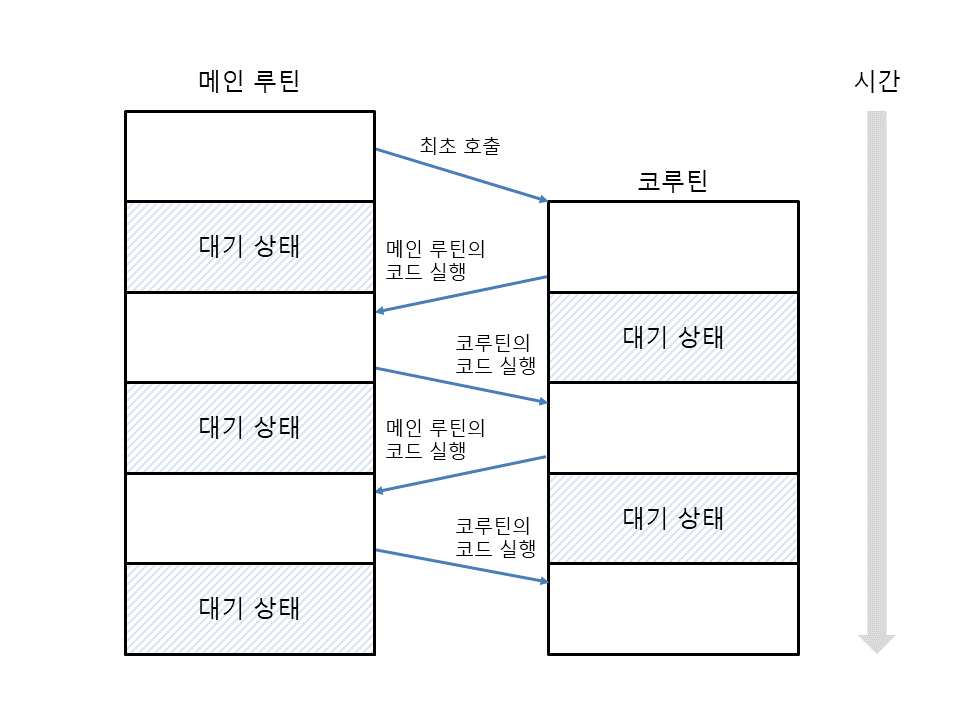

### 고급 데코레이터 (p187)

In [39]:
RETRIES_LIMIT = 3
def with_retry(retries_limit=RETRIES_LIMIT, allowed_exceptions=None):
    allowed_exceptions = allowed_exceptions or (ControlledException,)
    
    def retry(operation):
        @wraps(operation)
        def wrapped(*args, **kwargs):
            last_raised = None
            for _ in range(retries_limit):
                try:
                    return operation(*args, **kwargs)
                except allowed_exceptions as e:
                    logger.info("retrying %s due to %s", operation, e)
                    last_raised = e
            raise last_raised
        return wrapped
    return retry

# 새로운 함수가 추가될 때마다 들여쓰기가 추가되어 너무 많은 중첩 함수가 필요할 수 있다.

In [48]:
from typing import Optional, Sequence
from functools import wraps

class ControlledException(Exception):
    """도메인에서 발생하는 일반적인 예외"""

_DEFAULT_RETRIES_LIMIT = 3
class WithRetry:
    # __init__ 메서드에 파라미터를 전달한 다음 __call__ 매직 메서드에서 데코레이터의 로직을 구현하면 된다.
    def __init__(
        self,
        retries_limit: int = _DEFAULT_RETRIES_LIMIT,
        allowed_exceptions: Optional[Sequence[Exception]] = None
    ) -> None:
        self.retries_limit = retries_limit
        self.allowed_exceptions = allowed_exceptions or (ControlledException,)
    def __call__(self, operation):
        @wraps(operation)
        def wrapped(*args, **kwargs):
            last_raised = None
            
            for _ in range(retries_limit):
                try:
                    return operation(*args, **kwargs)
                except allowed_exceptions as e:
                    logger.warning(
                        "%s 재시도, 원인: %s",
                        operation.__qualname__, e
                    )
                    last_raised = e
            raise last_raised
            
        return wrapped
    
    
# 처리 순서
# 1. 데코레이터 객체 생성
# 2. 초기화 진행
# 3. @연산 호출
# 4. __call__ 매직 메서드 호출
@WithRetry(retries_limit=5)
def run_with_custom_retries_limit(task):
    return task.run()

In [50]:
def retry(operation):
    @wraps(operation)
    def wrapped(*args, **kwargs):
        last_raised = None
        RETRIES_LIMIT = 3

        for _ in range(RETRIES_LIMIT):
            try:
                return operation(*args, **kwargs)
            except ControlledException as e:
                logger.info("retrying %s", operation.__qualname__)
                last_raised = e

        raise last_raised

    return wrapped

In [ ]:
# 기본값을 가진 데코레이터
@retry()  # 괄호가 있는 경우: 첫번째 파라미터로 None이 전달
def my_function():
    pass

@retry  # 괄호가 없는 경우: 첫번째 파라미터로 함수가 전달
def your_function():
    pass


@decorator(x=3, y=4)
def my_function(x, y):
    return x + y
my_function()  # 7

### 데코레이터 활용 우수 사례 (p199)

1. 파라미터 변환
2. 코드 추적
3. 파라미터 유효성 검사
4. 재시도 로직 구현
5. 일부 반복 작업을 데코레이터로 이동하여 클래스 단순화

### 데코레이터의 활용 - 흔한 실수 피하기 (p201)

- 래핑된 객체를 일부 수정하더가 래핑된 객체를 수정하는 또다른 내부 함수를 정의했다면, 결과 객체를 외부에 노출하는 코드가 있어야 한다. (p209)

### 데코레이터와 클린 코드 (p212)
- 상속보다 컴포지션
  - 좋은 코드는 계층 구조를 만드는 것이 아니라, 작고 응집력 있는 추상화를 통해 재사용된다.
  - 구현상의 목적을 위해 추상화를 했다면 가급적 피하는 것이 좋으며, 기존의 도메인 객체를 손상시키지 않는 것이 훨씬 좋다.
- DRY 원칙
  - 신중하게 설계되지 않은 데코레이터는 코드의 복잡성을 증가시킨다.
  - 컴포넌트가 충분히 재사용 가능한 추상화를 했다고 인정받기 위해서는 적어도 3가지 이상의 애플리케이션에서 시험해봐야 한다.

- 데코레이터 사용을 권하는 경우
  - 처음부터 데코레이터를 만들지 않는다. 패턴이 생기고 데코레이터에 대한 추상화가 명확해지면 그 때 리팩토링을 한다.
  - 데코레이터가 적어도 3회 이상 필요한 경우에만 구현한다.
  - 데코레이터 코드를 최소한으로 유지한다.
  
**데코레이터에 하나 이상의 책임을 두면 안된다. SRP는 데코레이터에도 적용된다**

### 좋은 데코레이터 분석
1. 캡슐화와 관심사의 분리
- 좋은 데코레이터는 실제로 하는 일과 데코레이팅하는 일의 책임을 명확히 구분해야 한다. 어설프게 추상화 하면 안 된다. 즉, 데코레이터의 클라이언트는 내부에서 어떻게 구현했는지 전혀 알 수 없는 블랙박스 모드로 동작해야 한다.

2. 독립성
- 데코레이터가 하는 일은 독립적이어야 하며 데코레이팅되는 객체와 최대한 분리되어야 한다.

3. 재사용성
- 데코레이터는 하나의 함수 인스턴스에만 적용되는 것이 아니라 여러 유형에 적용 가능한 형태가 바람직하다. 왜냐하면 하나의 함수에만 적용된다면 데코레이터가 아니라 함수로 대신할 수도 있기 때문이다. 충분히 범용적이어야 한다.